<a href="https://colab.research.google.com/github/tbeucler/2023_MOOC_ECMWF/blob/main/Physically_constrained_postprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1: Physically-Constrained Post-Processing

⛈ Welcome to the first exercise of the "Physics-Guided Machine Learning" e-learning module of ECMWF's MOOC on Machine Learning in Weather and Climate 🌤

By the end of this first exercise, you will:

1.   Understand how constraining a machine learning model's output using physical knowledge can make it more consistent and trustworthy,
2.   Know how to use *custom layers* to enforce general nonlinear constraints within a neural network, and
3.   Practice what you learned about post-processing in Tier 1 on a real-world application case. 



While this notebook's completion time may widely vary depending on your programming experience, we estimate it will average to 30 minutes for this MOOC's students. This notebook provides a minimal reproducible example of the work described in the following preprint:

[Zanetta, Francesco, Daniele Nerini, Tom Beucler, and Mark A. Liniger. "Physics-constrained deep learning postprocessing of temperature and humidity."](https://arxiv.org/abs/2212.04487), 

and relies on the more general physically-constrained framework described in the following preprint: 

[Beucler, T., M. Pritchard, S. Rasp, P. Gentine, J. Ott, and P. Baldi. "Enforcing analytic constraints in neural-networks emulating physical systems."](https://arxiv.org/abs/1909.00912)

We provide an anonymized sample of our data. This pedagogical exercise would not have been possible without the code and contribution of [Francesco Zanetta (MeteoSwiss, ETH)](https://github.com/frazane). 

We will be relying on PyTorch, whose documentation you can find [here](https://pytorch.org/), and the notebooks assume that you will run them on Google Colab (Google Colab tutorial [at this link](https://colab.research.google.com/drive/16pBJQePbqkz3QFV54L4NIkOn1kwpuRrj)). 

While everything can be run locally and there are only a handful of lines that use Google specific libraries, we encourage beginners to use Google Colab not to run into [Python virtual environment](https://docs.python.org/3/tutorial/venv.html) issues. 

Before we get started, if you are struggling with some of the exercises, do not hesitate to:


*   Use a direct Internet search, or [stackoverflow](https://stackoverflow.com/)
*   Debug your program, e.g. by following [this tutorial](https://swcarpentry.github.io/python-novice-inflammation/11-debugging/index.html)
*   Use assertions, e.g. by following [this tutorial](https://swcarpentry.github.io/python-novice-inflammation/10-defensive/index.html)
*   Ask for help on the MOOC's Moodle Forum

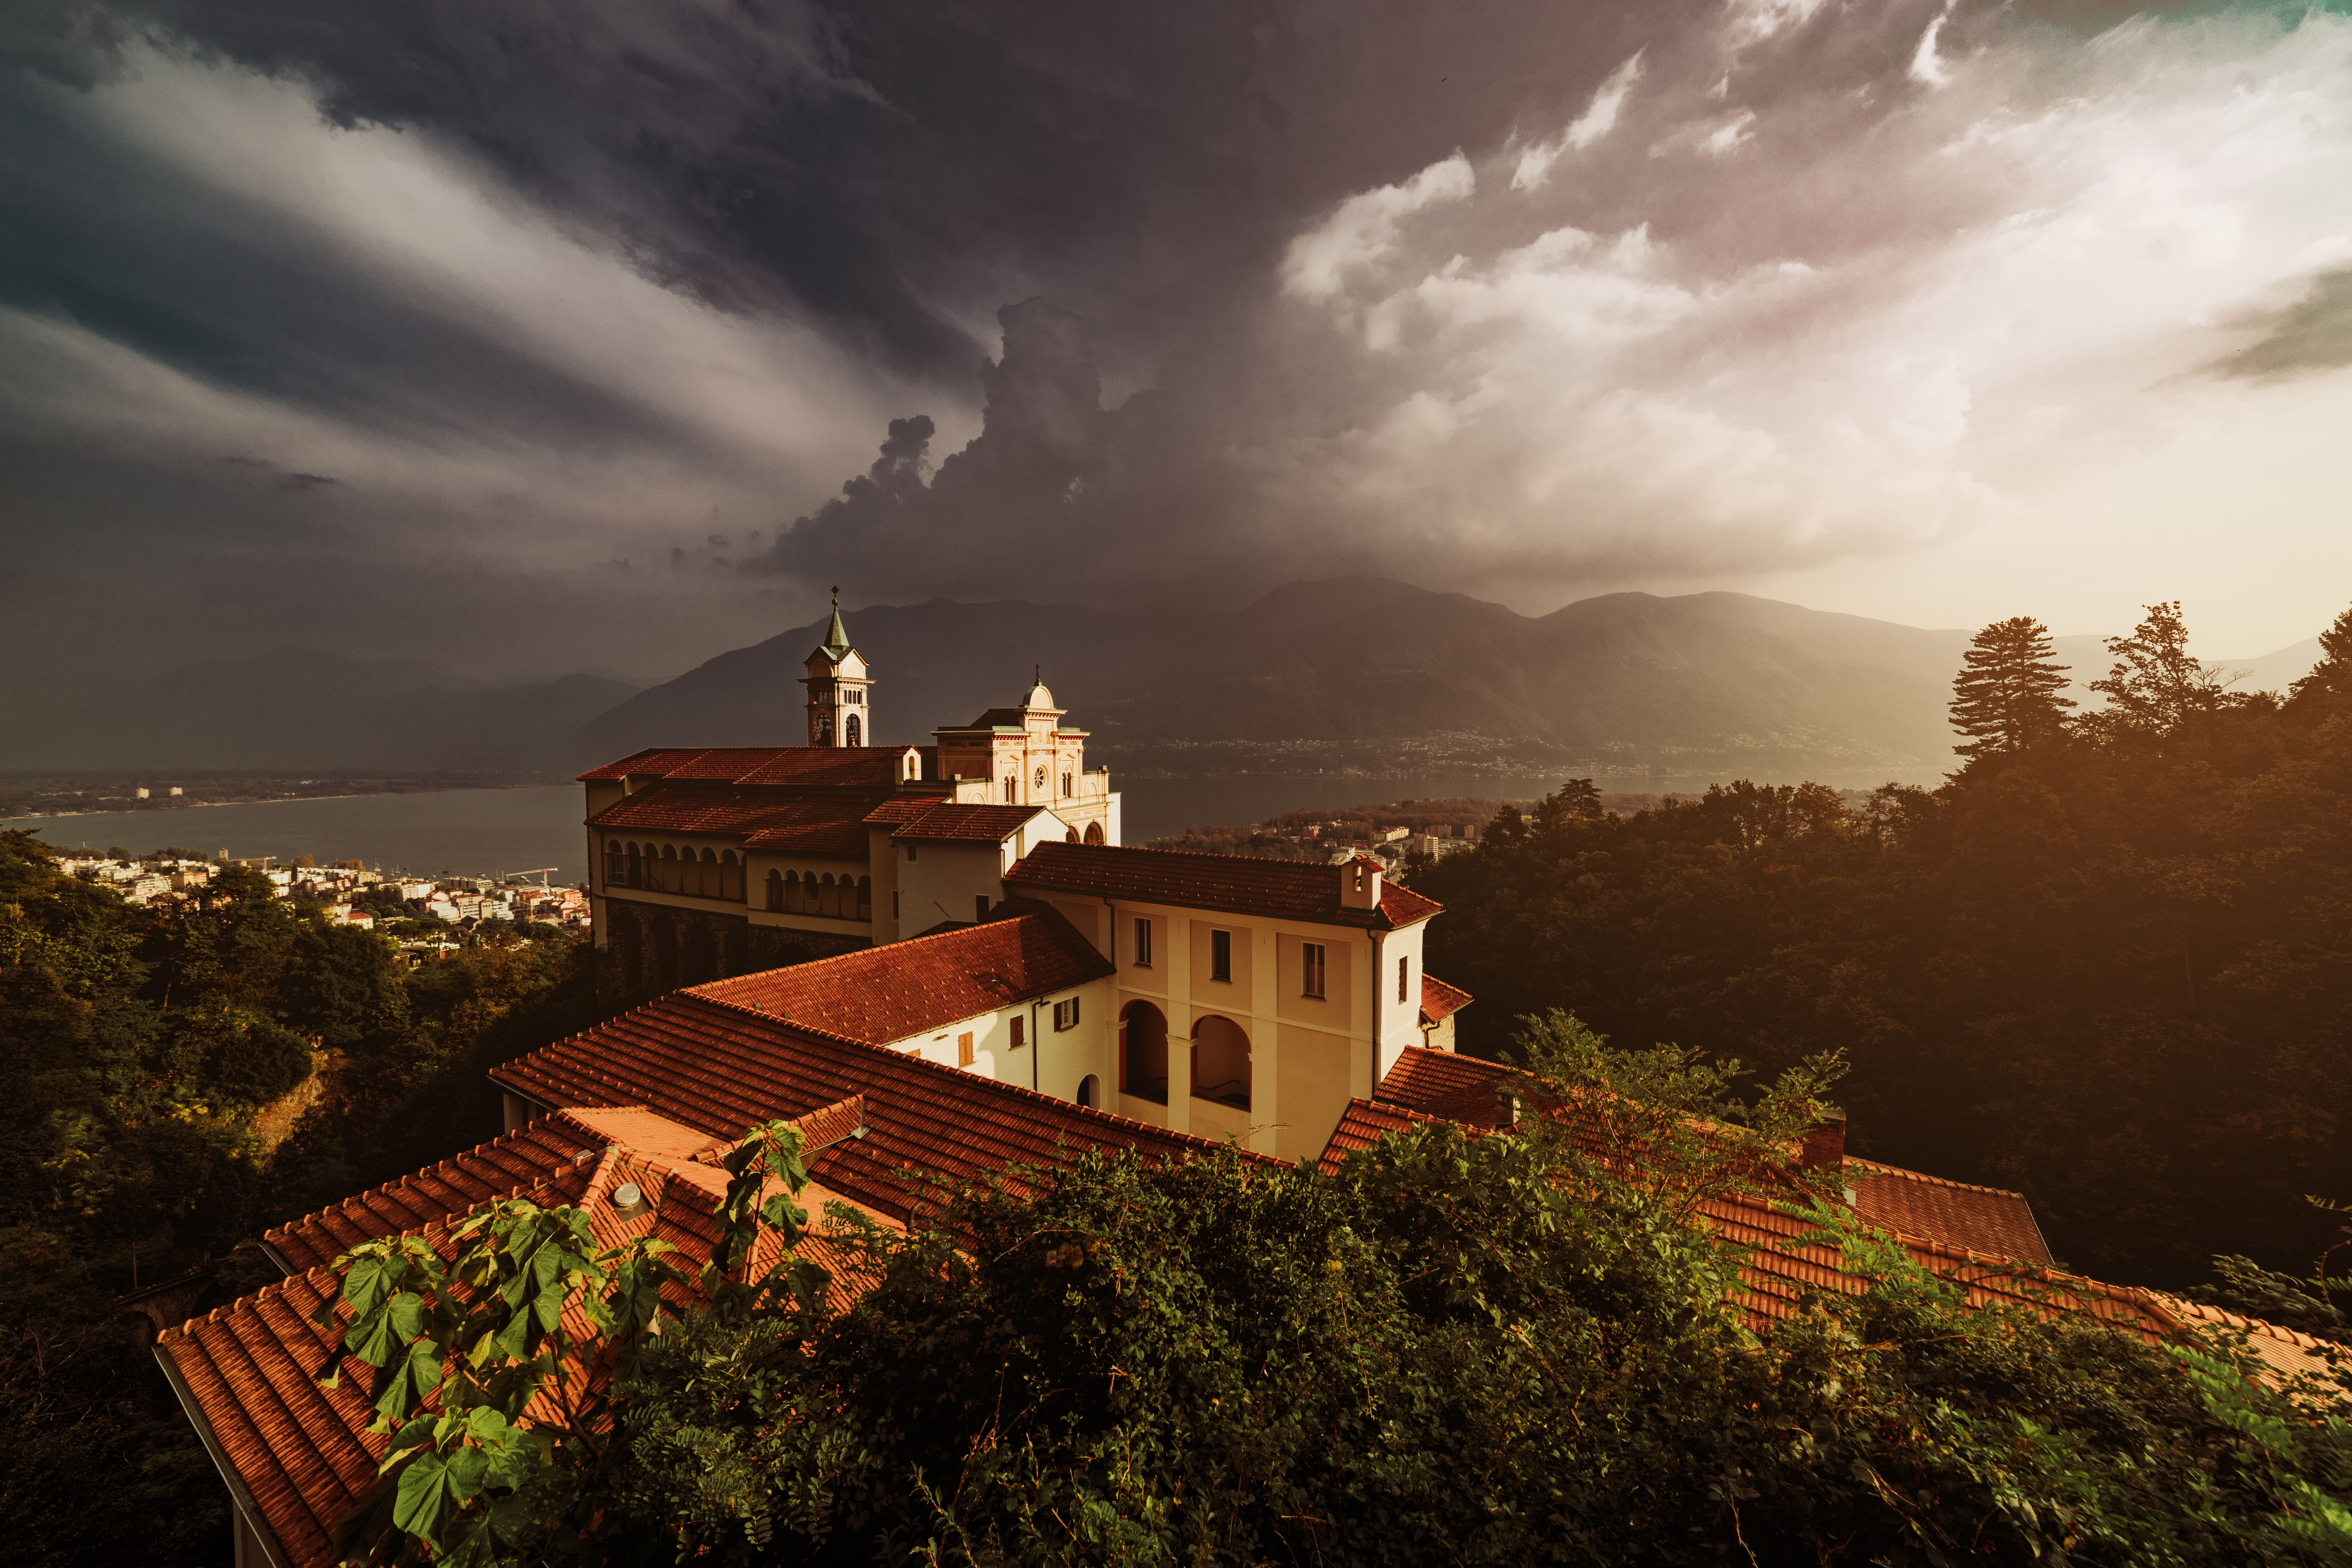

🌧 A storm is quickly approaching the [MeteoSwiss](https://www.meteoswiss.admin.ch/) agency in Locarno! Will you be able to post-process the weather it brings without violating the laws of thermodynamics? 🌡

*Source: Photo by [Marcell Faber](https://stock.adobe.com/ch_de/contributor/206314229/marcell-faber?load_type=author&prev_url=detail) licensed under the [Adobe Stock standard license](https://stock.adobe.com/license-terms)* 

## Part I. Configuration and requirements

In [1]:
#@title  Run this cell for preliminary requirements. Double click for the source
!sudo apt-get update -y
!sudo apt-get install python3.10
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 2
!curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
!python3 get-pip.py --force-reinstall
!python3 -m pip install ipython ipython_genutils ipykernel jupyter_console prompt_toolkit httplib2 astor
!ln -s /usr/local/lib/python3.7/dist-packages/google \
       /usr/local/lib/python3.10/dist-packages/google

!pip install numpy torch xarray==2022.10.0 netcdf4

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [920 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:11 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,017 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:13 http://security.ubuntu.com/ubuntu focal-se

In [3]:
#@title  Run this cell for Python library imports. Double click for the source
from itertools import chain

import pooch
import numpy as np 
import xarray as xr
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch import optim

torch.manual_seed(1)
np.random.seed(1)

In [4]:
#@title  Run this cell to load the data using the pooch library. Double click for the source
path_data = 'https://unils-my.sharepoint.com/:u:/g/personal/tom_beucler_unil_ch/'
x_path = path_data + 'EdAG3RBBgk5Kmvo54RPgT2kBp-NJqqGF6Il-gTmh9DbdeA?download=1'
y_path = path_data + 'EdVQCVKqnb9Bh495opeuRCEBBZFPDdG0g3xSpIFgNGJeJA?download=1'
x_open = pooch.retrieve(x_path,known_hash='c6acaf62051b81dfd3d5a4aa516d545615fd2597c8c38f4db4e571a621201878')
y_open = pooch.retrieve(y_path,known_hash='6265a5f0272e5427c823b95725b8aabbc48a9a97d7554fd5732e6c4b480f3ab3')
# load data
x = (
    xr.open_dataset(x_open)
    .set_coords(["forecast_reference_time","t", "station_id"])
    .set_xindex("forecast_reference_time")
    .to_array("var")
    .transpose("s","var")
)
y = (
    xr.open_dataset(y_open)
    .set_coords(["forecast_reference_time","t"])
    .set_xindex("forecast_reference_time")
    .to_array("var")
    .transpose("s","var")
)

## Part II. Pre-processing your data for deep learning

In [ ]:
BATCH_SIZE = 1024
ALPHA = 0.995
LR = 0.0008
UNITS_L1 = 128
UNITS_L2 = 256
EMBEDDING_SIZE=5
MAX_EPOCHS = 20
PATIENCE = 5

In [ ]:
# split data
train_sel = dict(forecast_reference_time=slice("2017-01-01","2019-12-25"))
val_sel = dict(forecast_reference_time=slice("2020-01-01","2020-12-25"))
test_sel = dict(forecast_reference_time=slice("2021-01-01","2021-12-31T23:59"))

train_x, train_y = x.sel(train_sel), y.sel(train_sel)
val_x, val_y = x.sel(val_sel), y.sel(val_sel)
test_x, test_y = x.sel(test_sel), y.sel(test_sel)

In [ ]:
# normalize input data
train_x_mean = train_x.mean("s")
train_x_std = train_x.std("s")

train_x = (train_x - train_x_mean) / train_x_std
val_x = (val_x - train_x_mean) / train_x_std
test_x = (test_x - train_x_mean) / train_x_std

In [ ]:
# prepare torch dataloaders

class Data(Dataset):
    def __init__(self, x, y):

        self.x = torch.tensor(x.values).to("cuda:0")
        self.y = torch.tensor(y.values).to("cuda:0")
        self.station_id = torch.tensor(x.station_id.values, dtype=torch.int32).to("cuda:0")
        self.y_coords = y.coords

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return (self.x[idx], self.station_id[idx]), self.y[idx]


class DataLoader(object):
    def __init__(self, dataset, batch_size, shuffle=False):
        self.dataset = dataset
        self.dataset_len = self.dataset.x.shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches

    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.dataset.x = self.dataset.x[r]
            self.dataset.station_id = self.dataset.station_id[r]
            self.dataset.y = self.dataset.y[r]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = self.dataset[self.i : self.i + self.batch_size]
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches



train = Data(train_x, train_y)
val = Data(val_x, val_y)

train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val, batch_size=BATCH_SIZE * 8)

## Part III. Physically-constrained neural network

In [ ]:
class Net(nn.Module):

    out_bias = [15.0, 10.0, 900.0, 70.0, 5.0]  # t, t_d, p, rh, r
    out_bias_constrained = [15.0, 5.0, 900]  # t, t_def, p

    def __init__(self, in_size, n_stations, embedding_size, l1, l2, constraint=False):
        super(Net, self).__init__()
        self.embedding = nn.Embedding(n_stations, embedding_size)
        self.l1 = nn.Linear(in_size + embedding_size, l1)
        self.l2 = nn.Linear(l1, l2)
        if constraint:
            self.out = nn.Sequential(nn.Linear(l2, 3), PhysicsLayer())
            self.out[0].bias = nn.Parameter(torch.Tensor(self.out_bias_constrained))
        else:
            self.out = nn.Linear(l2, 5)
            self.out.bias = nn.Parameter(torch.Tensor(self.out_bias))


    def forward(self, x, station_id):
        station_embedding = self.embedding(station_id)
        x = torch.concat([x, station_embedding], dim=-1)
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        out = self.out(x)
        return out


class PhysicsLayer(nn.Module):
    def __init__(self):
        super(PhysicsLayer, self).__init__()

    def forward(self, direct):
        t, t_def, p = direct[:, 0], direct[:, 1], direct[:, 2]
        t_d = t - torch.relu(t_def)
        e_s = torch.where(
            t >= 0.0,
            6.107 * torch.exp((17.368 * t) / (t + 238.83)),
            6.108 * torch.exp((17.856 * t) / (t + 245.52)),
        )
        e = torch.where(
            t >= 0.0,
            6.107 * torch.exp((17.368 * t_d) / (t_d + 238.83)),
            6.108 * torch.exp((17.856 * t_d) / (t_d + 245.52)),
        )
        rh = e / e_s * 100.0
        r = 622.0 * (e / (p - e))
        pred = torch.stack([t, t_d, p, rh, r], dim=1)
        return pred

Models and losses

- the basic building block for all models is a fully connected architecture wrapped in `Net`, where we initialize the output bias manually to values that are in the same order of magnitude as our targets.
- optionally, the module may include the `PhysicsLayer`, which incorporates the physical constraints.
- we define the `MultiTaskLoss` class which implements the uncertainty-weighted loss function, and optionally adds the physics-based loss term computed with `physical_penalty`.


## Part IV. Multi-task loss function

In [ ]:




class MultiTaskLoss(nn.Module):
    def __init__(self, alpha=0.0, mask=None, log_var_init=None):
        super(MultiTaskLoss, self).__init__()
        self.alpha = alpha
        self.mask = [True] * 5 if mask is None else mask

        log_var = torch.zeros(5) if log_var_init is None else log_var_init

        self.log_var = nn.Parameter(log_var)

        self.hp = {"alpha": alpha}

    def forward(self, pred, y):
        loss = torch.mean((pred - y) ** 2, axis=0)
        loss = torch.exp(-self.log_var) * loss + self.log_var
        loss = torch.sum(loss[self.mask])
        rh_res, r_res = physical_penalty(pred)
        physics_loss = rh_res / torch.var(y[:, 3]) + r_res / torch.var(y[:, 4])
        if self.alpha > 0.0:
            loss = (1 - self.alpha) * loss + self.alpha * physics_loss
        return loss, physics_loss


def physical_penalty(pred):
    t, t_d, p, rh, r = pred[:, 0], pred[:, 1], pred[:, 2], pred[:, 3], pred[:, 4]
    e = torch.where(
        t >= 0.0,
        6.107 * torch.exp((17.368 * t_d) / (t_d + 238.83)),
        6.108 * torch.exp((17.856 * t_d) / (t_d + 245.52)),
    )
    e_s = torch.where(
        t >= 0.0,
        6.107 * torch.exp((17.368 * t) / (t + 238.83)),
        6.108 * torch.exp((17.856 * t) / (t + 245.52)),
    )
    rh_derived = e / (e_s + 1e-5) * 100.0
    r_derived = 622.0 * (e / (p - e))

    return (
        torch.mean((rh_derived - rh) ** 2),
        torch.mean((r_derived - r) ** 2),
    )

## Part V. Model training

## Part VI. Model evaluation

In [ ]:
# training functions

def training_step(model, loss_fn, optimizer, train_dataloader):
    model.train(True)
    loss_fn.train(True)
    running_loss = 0.0
    num_batches = len(train_dataloader)
    iterator = enumerate(train_dataloader)
    for i, (X, y) in iterator:
        pred = model(*X)
        loss, p = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / num_batches


def validation_step(model, loss_fn, val_dataloader):
    model.train(False), loss_fn.train(False)
    val_loss = 0.0
    val_p = 0.0
    val_mae = 0.0
    with torch.no_grad():
        iterator = val_dataloader
        for X, y in iterator:
            pred = model(*X)
            loss, p = loss_fn(pred, y)
            val_loss += loss.item()
            val_p += p.item()
            val_mae += torch.mean(torch.abs(pred - y), dim=0)
    val_loss /= len(val_dataloader)
    val_p /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    return val_loss, val_p, val_mae


def fit(model, loss_fn, train_dl, val_dl, max_epochs=20, max_patience=5):
    optimizer = optim.Adam(
        chain(model.parameters(), loss_fn.parameters()), lr=LR
    )
    best_val_nmae = torch.inf
    val_y_std = val.y.std(dim=0)
    for epoch in range(max_epochs):

        train_loss = training_step(model, loss_fn, optimizer, train_dl)
        val_loss, val_p, val_mae = validation_step(model, loss_fn, val_dl)
        val_nmae = torch.mean((val_mae / val_y_std))

        if val_nmae < best_val_nmae:
            best_val_nmae = val_nmae
            best_model = model
            patience = 0
        else:
            patience += 1
            if patience == max_patience:
                break

        print(
            f"{epoch+1:<2}{'':>4}loss: {train_loss:<10.4}val_loss: {val_loss:<10.4}"
            f"val_t_mae: {val_mae[0]:<10.4} val_rh_mae: {val_mae[3]:<10.4}"
            f"val_nmae: {val_nmae:<10.4} val_p: {val_p:<10.4}"
        )

    return best_model

In [ ]:
torch.device("cuda:0")

device(type='cuda', index=0)

In [ ]:

unconstrained = Net(
    11, 131, EMBEDDING_SIZE, UNITS_L1, UNITS_L2, constraint=False
).to("cuda:0")
loss = MultiTaskLoss().to("cuda:0")

unconstrained = fit(unconstrained, loss, train_dl, val_dl, max_epochs=20, max_patience=5)

1     loss: 127.8     val_loss: 14.1      val_t_mae: 1.529      val_rh_mae: 9.658     val_nmae: 0.218      val_p: 0.03546   
2     loss: 13.66     val_loss: 13.51     val_t_mae: 1.5        val_rh_mae: 9.527     val_nmae: 0.2146     val_p: 0.02282   
3     loss: 13.47     val_loss: 13.41     val_t_mae: 1.497      val_rh_mae: 9.454     val_nmae: 0.2135     val_p: 0.02837   
4     loss: 13.4      val_loss: 13.33     val_t_mae: 1.475      val_rh_mae: 9.364     val_nmae: 0.2116     val_p: 0.03328   
5     loss: 13.34     val_loss: 13.38     val_t_mae: 1.498      val_rh_mae: 9.354     val_nmae: 0.2126     val_p: 0.05927   
6     loss: 13.31     val_loss: 13.32     val_t_mae: 1.471      val_rh_mae: 9.384     val_nmae: 0.2121     val_p: 0.03494   
7     loss: 13.28     val_loss: 13.31     val_t_mae: 1.465      val_rh_mae: 9.301     val_nmae: 0.2106     val_p: 0.02914   
8     loss: 13.26     val_loss: 13.3      val_t_mae: 1.46       val_rh_mae: 9.276     val_nmae: 0.2101     val_p: 0.02525   


In [ ]:
torch.set_num_threads(2)

architecture_constrained = Net(
    11, 131, EMBEDDING_SIZE, UNITS_L1, UNITS_L2, constraint=True
).to("cuda:0")
loss = MultiTaskLoss().to("cuda:0")

architecture_constrained = fit(architecture_constrained, loss, train_dl, val_dl, max_epochs=20, max_patience=5)

1     loss: 119.7     val_loss: 14.09     val_t_mae: 1.542      val_rh_mae: 9.599     val_nmae: 0.218      val_p: 3.05e-11  
2     loss: 13.67     val_loss: 13.48     val_t_mae: 1.509      val_rh_mae: 9.577     val_nmae: 0.2154     val_p: 2.971e-11 
3     loss: 13.49     val_loss: 13.5      val_t_mae: 1.491      val_rh_mae: 9.369     val_nmae: 0.2131     val_p: 2.957e-11 
4     loss: 13.42     val_loss: 13.37     val_t_mae: 1.484      val_rh_mae: 9.22      val_nmae: 0.2103     val_p: 3.112e-11 
5     loss: 13.37     val_loss: 13.35     val_t_mae: 1.481      val_rh_mae: 9.341     val_nmae: 0.2114     val_p: 3.02e-11  
6     loss: 13.34     val_loss: 13.41     val_t_mae: 1.473      val_rh_mae: 9.221     val_nmae: 0.2114     val_p: 3.193e-11 
7     loss: 13.32     val_loss: 13.3      val_t_mae: 1.479      val_rh_mae: 9.186     val_nmae: 0.2093     val_p: 3.152e-11 
8     loss: 13.3      val_loss: 13.33     val_t_mae: 1.478      val_rh_mae: 9.188     val_nmae: 0.2097     val_p: 3.081e-11 


In [ ]:
loss_constrained = Net(
    11, 131, EMBEDDING_SIZE, UNITS_L1, UNITS_L2, constraint=False
).to("cuda:0")
constrained_loss = MultiTaskLoss(alpha=ALPHA).to("cuda:0")

loss_constrained = fit(loss_constrained, constrained_loss, train_dl, val_dl, max_epochs=20, max_patience=5)

1     loss: 0.661     val_loss: 0.07373   val_t_mae: 1.561      val_rh_mae: 9.753     val_nmae: 0.2199     val_p: 0.002564  
2     loss: 0.06939   val_loss: 0.06902   val_t_mae: 1.53       val_rh_mae: 9.642     val_nmae: 0.2168     val_p: 0.001339  
3     loss: 0.06841   val_loss: 0.07015   val_t_mae: 1.52       val_rh_mae: 9.607     val_nmae: 0.2161     val_p: 0.002464  
4     loss: 0.06804   val_loss: 0.0682    val_t_mae: 1.504      val_rh_mae: 9.515     val_nmae: 0.2144     val_p: 0.0009904 
5     loss: 0.0678    val_loss: 0.06812   val_t_mae: 1.501      val_rh_mae: 9.495     val_nmae: 0.2139     val_p: 0.0009515 
6     loss: 0.06763   val_loss: 0.06784   val_t_mae: 1.489      val_rh_mae: 9.477     val_nmae: 0.2132     val_p: 0.0009112 
7     loss: 0.06748   val_loss: 0.06794   val_t_mae: 1.489      val_rh_mae: 9.49      val_nmae: 0.2132     val_p: 0.0008872 
8     loss: 0.06736   val_loss: 0.06807   val_t_mae: 1.497      val_rh_mae: 9.469     val_nmae: 0.2132     val_p: 0.001011  


In [ ]:
test = Data(test_x, test_y)
test_dl = DataLoader(test, batch_size=BATCH_SIZE * 16)


def evaluate(model, test_dl):
    model.eval()
    mae, mse = 0.0, 0.0
    with torch.no_grad():
        iterator = test_dl
        for X, y in iterator:
            pred = model(*X)
            mae += torch.mean(torch.abs(pred - y), dim=0)
            mse += torch.mean((pred - y)**2, dim=0)
    return mae / len(test_dl), mse / len(test_dl) 

In [ ]:
evaluate(unconstrained, test_dl)

(tensor([1.5000, 1.6534, 0.9950, 9.3079, 0.5917], device='cuda:0'),
 tensor([  3.9038,   5.4306,   2.1298, 150.9891,   0.6418], device='cuda:0'))

In [ ]:
evaluate(architecture_constrained, test_dl)

(tensor([1.5040, 1.6675, 1.0268, 9.3120, 0.5956], device='cuda:0'),
 tensor([  3.9215,   5.5530,   2.2092, 154.3734,   0.6595], device='cuda:0'))

In [ ]:
evaluate(loss_constrained, test_dl)

(tensor([1.5001, 1.6435, 1.0024, 9.3098, 0.5825], device='cuda:0'),
 tensor([  3.9243,   5.5040,   2.1578, 151.1862,   0.6311], device='cuda:0'))

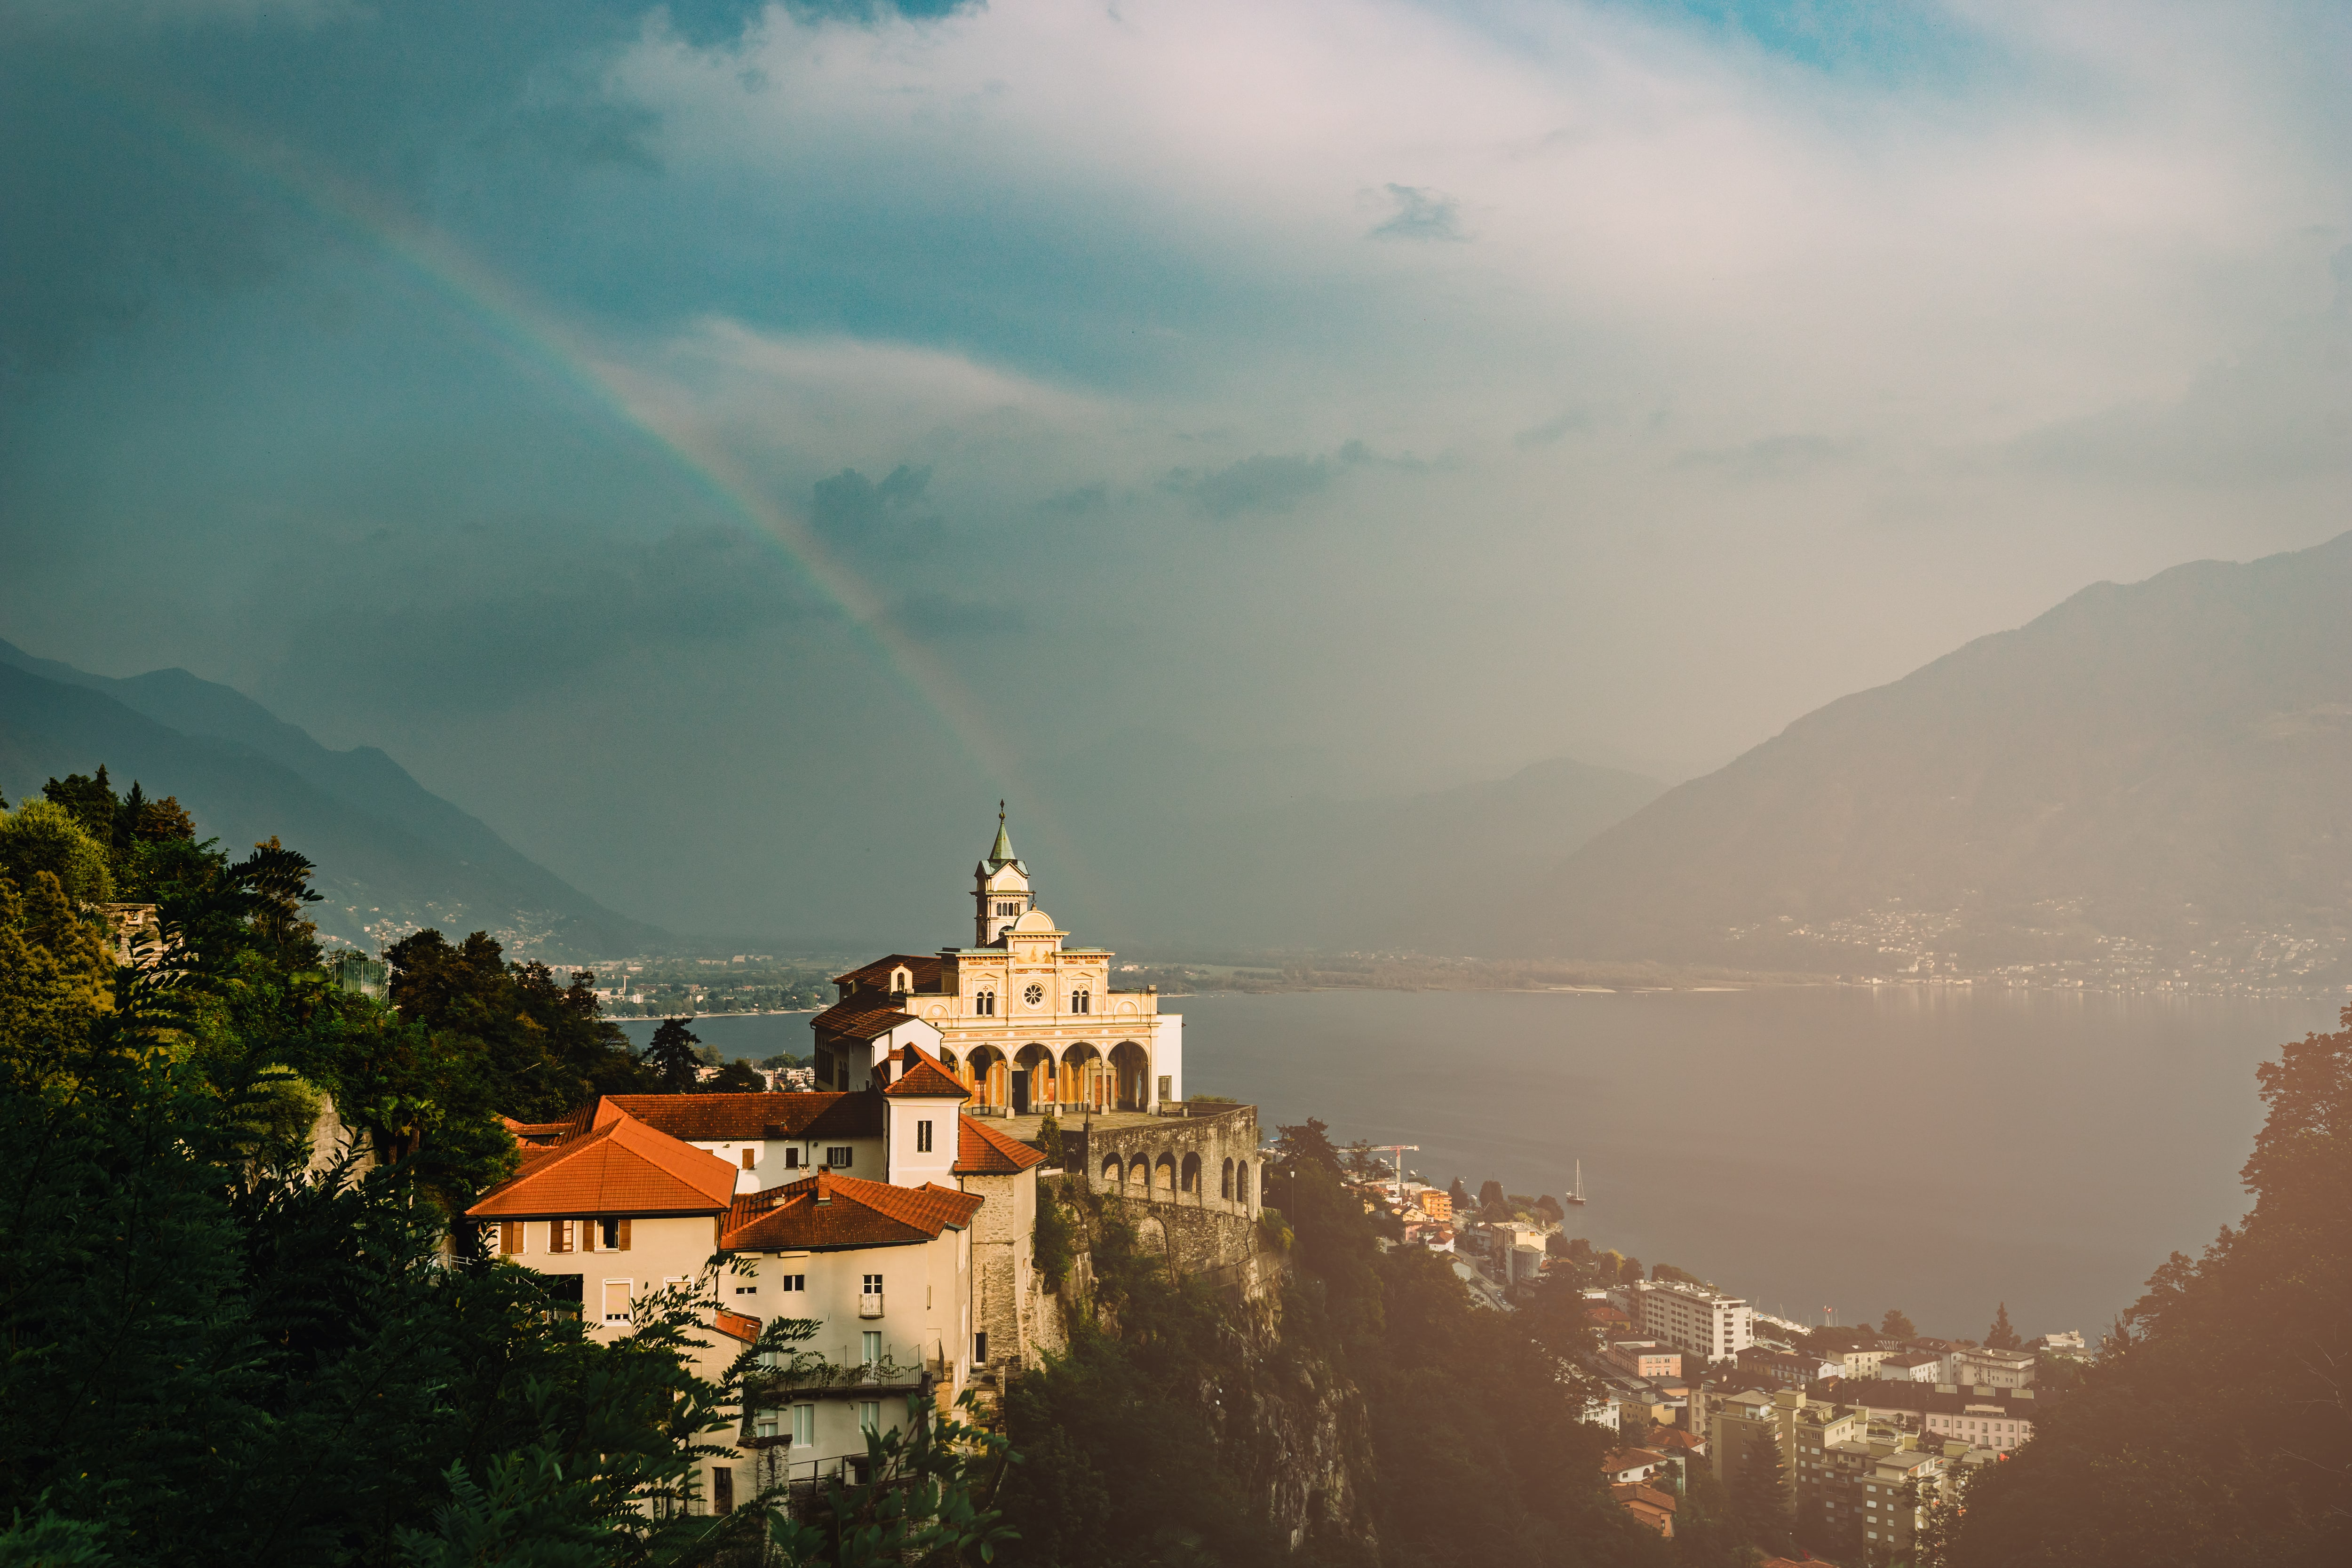

🌈 Phew, after your successful physically-constrained, deep learning forecast, the storm is over. But hopefully, your quest for knowledge isn't 📚 Stay tuned for this session's second exercise, in which you will learn how to use physical knowledge, this time to make a neural network generalize over vastly different climates!

*Source: Photo by [Marcell Faber](https://stock.adobe.com/ch_de/contributor/206314229/marcell-faber?load_type=author&prev_url=detail) licensed under the [Adobe Stock standard license](https://stock.adobe.com/license-terms)* 